In [1]:
import numpy as np
import pandas as pd

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nltk.translate.bleu_score import sentence_bleu

# Model

In [2]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

In [3]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

In [4]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [5]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.attention = BahdanauAttention(self.dec_units)

        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [6]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))
        
    def translate(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                     enc_output=enc_output,
                                     mask=(input_tokens!=0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            done = done | (new_tokens == self.end_token)
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

    
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def tf_translate(self, input_text):
        return self.translate(input_text)

# Evaluation

In [7]:
def to_lower_case_eng(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 65), tf.less(chars, 91))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [8]:
def to_lower_case_rus(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 1040), tf.less(chars, 1072))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [9]:
def to_lower_case_oss(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 198), tf.less(chars, 199))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [10]:
def tf_lower_and_split_punct(text):
    # Замена символов 'æ' с кодом 1237 на символ 'æ' с кодом 230
    text = tf.strings.regex_replace(text, 'ӕ', 'æ')
    # Замена символа '—' на '-'
    text = tf.strings.regex_replace(text, '—', '-')
    
    text = tf_text.normalize_utf8(text, 'NFKD')
    
    # Нижний регистр
    text = to_lower_case_rus(text)
    text = to_lower_case_eng(text)
    text = to_lower_case_oss(text)
    
    # Удаление лишних символов, кроме списка представленных.
    text = tf.strings.regex_replace(text, '[^ a-zа-яæ.?!,-`…:;\']', '')
    # Добавьте пробелы вокруг знаков препинания.
    text = tf.strings.regex_replace(text, '[.?!,-`…:;\']', r' \0 ')
    # Удаление лишних пробелов.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [11]:
def plot_attention(attention, sentence, predicted_sentence):
    plt.figure(figsize=(10,8), dpi=80)
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    fontdict = {'fontsize': 14}
    
    attention = attention[:len(predicted_sentence), :len(sentence)]

    cax = ax.matshow(attention, cmap='viridis', vmin=0.0)   
    fig.colorbar(cax)

    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict,rotation=90)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.set_xlabel('Входная последовательность')
    ax.set_ylabel('Выходная последовательность')
    plt.suptitle('Attention')

In [12]:
def evaluation(sentance, reference, n_gram=4):
    result = reloaded.tf_translate(tf.constant([sentance]))
    hypothetic = result['text'][0].numpy().decode()
    
    reference = tf_lower_and_split_punct(reference).numpy().decode()
    reference = " ".join(reference.split()[1:-1])
    
    print(f'Orginal: {sentance}')
    print(f'Human Translation: {reference}')    
    print(f'Machine Translation: {hypothetic}')
    if n_gram == 1:
        print(f'BLEU 1-gram: {sentence_bleu([hypothetic], reference, weights = [1])}')
    elif n_gram == 2:
        print(f'BLEU 2-gram: {sentence_bleu([hypothetic], reference, weights = [0.5, 0.5])}')
    elif n_gram == 3:
        print(f'BLEU 3-gram: {sentence_bleu([hypothetic], reference, weights = [0.33, 0.33, 0.33])}')
    else:
        print(f'BLEU 4-gram: {sentence_bleu([hypothetic], reference, weights = [0.25, 0.25, 0.25, 0.25])}')
    plot_attention(result['attention'][0], sentance, result['text'][0])
    
    print('='*15)

# Load model and data

In [13]:
def load_data(path):
    with open(path, encoding='utf-8') as f:
        text = f.read()

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    source = [source for source, target in pairs]
    target = [target for source, target in pairs]

    return source, target

In [14]:
path = 'rus-eng-mini'
path_to_file = f'Date/{path}.txt'
source, target = load_data(path_to_file)

In [15]:
reloaded = tf.saved_model.load(f'translator-{path}')

In [16]:
data = pd.DataFrame()
data['Source'] = source
data['Target'] = target

# Test

Orginal: Как вы познакомились с Томом?
Human Translation: how did you meet tom ?
Machine Translation: how did you meet tom ?
BLEU 4-gram: 1.0


C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_25512/1786583011.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict,rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_25512/1786583011.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

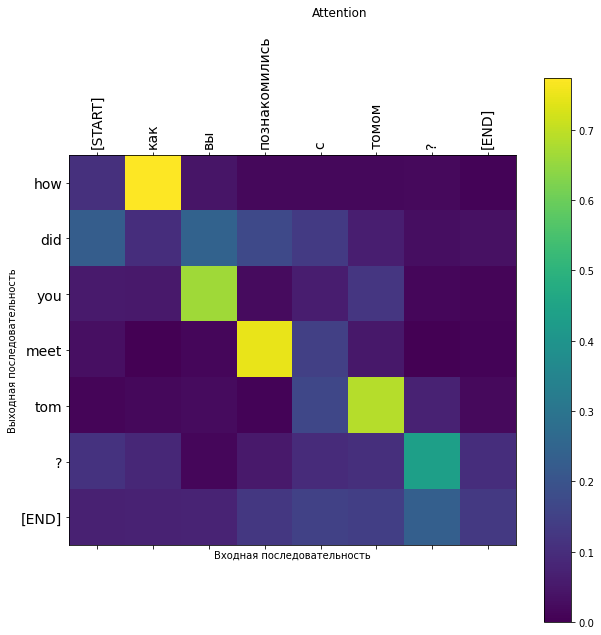

In [21]:
u = data.sample().reset_index()
evaluation(u['Source'][0], u['Target'][0])